In [1]:
# Evaluate the ML model

import tensorflow as tf
from tensorflow import keras
import os
import glob
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import plot_loss, encoder_files_to_tensors, get_best_model_timestamp
from utils import load_model_data_new, unnormalize_params, assess_decoder
from models import Encoder, mse_loss_encoder, mse_loss_decoder


2022-09-19 10:06:39.669304: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-19 10:06:39.672488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-09-19 10:06:39.672498: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
# Initialize parameters
data_dir = '/eos/kiliakis/tomo_data/datasets'

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TESTING_PATH = os.path.join(ML_dir, 'TESTING')
assert os.path.exists(TESTING_PATH)

# First the training data
files = glob.glob(TESTING_PATH + '/*.pk')

import time
start_t = time.time()
# Shuffle them
np.random.shuffle(files)
# read input, divide in features/ label, create tensors
x_test, y_test = encoder_files_to_tensors(files)
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(files):.3f}')

# VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')
# assert os.path.exists(VALIDATION_PATH)

# # Then the validation data
# files = glob.glob(VALIDATION_PATH + '/*.pk')

# # Shuffle them
# np.random.shuffle(files)
# # read input, divide in features/ label, create tensors
# x_valid, y_valid = encoder_files_to_tensors(files)


Elapsed time: 0.731, Per file: 0.001


In [3]:
# Model to load
# timestamp = '2022_09_16_15-30-35'
# timestamp = '2022_09_19_09-41-03'
timestamp = get_best_model_timestamp('./trials', model='enc')

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')
assert os.path.exists(weights_dir)
os.makedirs(plots_dir, exist_ok=True)

# load the model
encoder = keras.models.load_model(os.path.join(weights_dir, 'encoder.h5'))


In [4]:

# Evaluate the model on the test and validation data

test_loss = encoder.evaluate(x_test, y_test)
print(f'Test loss: {test_loss:.3f}')
# valid_loss = encoder.evaluate(x_valid, y_valid)
# print(f'Valid loss: {valid_loss:.3f}')

# get predictions
test_pred = encoder.predict(x_test, verbose=False)
# valid_pred = encoder.predict(x_valid, verbose=False)
y_test = np.array(y_test)

# Calculate error per variable
mses = mean_squared_error(y_test, test_pred, multioutput='raw_values')


44/44 [==============================] - 1s 14ms/step - loss: 0.1230
Test loss: 0.123


In [5]:
var_names = ['phase_error', 'energy_error',
             'bunch_length', 'intensity', 'Volt_rf', 'mu', 'Vrf_SPS']
# report
print('Variable\tMSE')
for name, mse in zip(var_names, mses):
    print(f'{name}:\t{mse:.4f}')


Variable	MSE
phase_error:	0.0122
energy_error:	0.0141
bunch_length:	0.0216
intensity:	0.6873
Volt_rf:	0.0127
mu:	0.0654
Vrf_SPS:	0.0476


phase_error [7.62454874e-01 1.47292419e-01 5.41516245e-02 2.02166065e-02
 6.49819495e-03 5.77617329e-03 2.16606498e-03 0.00000000e+00
 7.22021661e-04 7.22021661e-04]
energy_error [9.16245487e-01 5.63176895e-02 1.94945848e-02 5.05415162e-03
 1.44404332e-03 0.00000000e+00 0.00000000e+00 7.22021661e-04
 0.00000000e+00 7.22021661e-04]
bunch_length [8.42599278e-01 1.03971119e-01 3.46570397e-02 9.38628159e-03
 7.94223827e-03 0.00000000e+00 0.00000000e+00 7.22021661e-04
 0.00000000e+00 7.22021661e-04]
intensity [0.64909747 0.18628159 0.08953069 0.0433213  0.01805054 0.00794224
 0.00216606 0.00216606 0.00072202 0.00072202]
Volt_rf [0.73068592 0.14296029 0.05631769 0.02960289 0.01732852 0.00938628
 0.00433213 0.00505415 0.00216606 0.00216606]
mu [9.37906137e-01 4.62093863e-02 9.38628159e-03 3.61010830e-03
 0.00000000e+00 1.44404332e-03 0.00000000e+00 0.00000000e+00
 7.22021661e-04 7.22021661e-04]
Vrf_SPS [0.76967509 0.13140794 0.06064982 0.02166065 0.00722022 0.00361011
 0.00144404 0.00144404 0

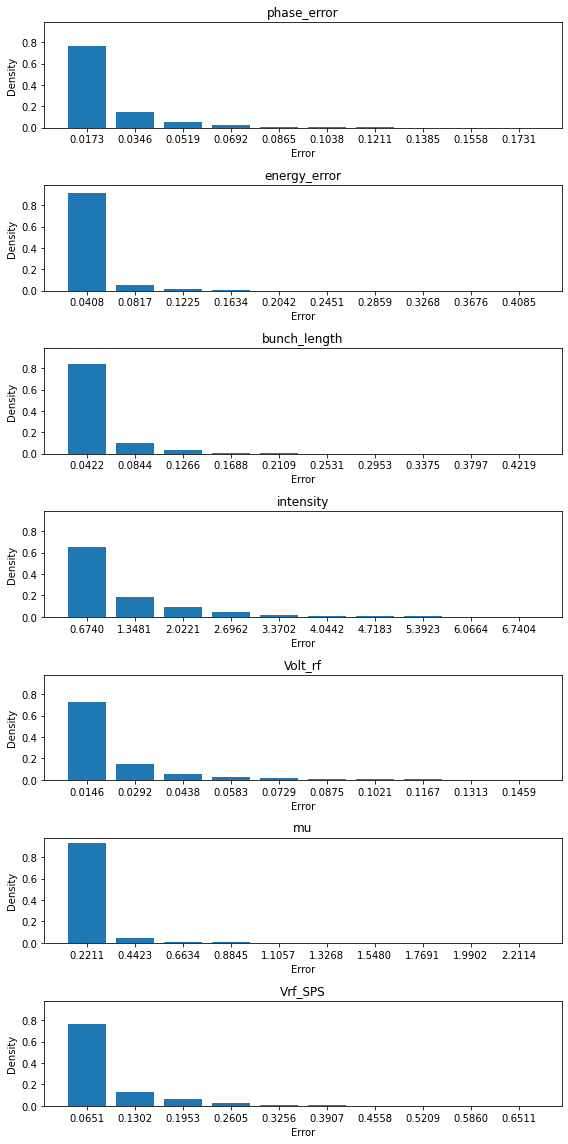

In [13]:
# Also generate MSE histogram
# print(valid_pred.shape)
square_errors = ((y_test - test_pred) * (y_test - test_pred))

fig, axes = plt.subplots(ncols=1, nrows=len(var_names), sharex=False, 
sharey=True, figsize=(8, 16))
for i, name in enumerate(var_names):
    hist,edges = np.histogram(square_errors[:, i], bins=10, density=False)
    hist = hist / len(square_errors[:, i])
    print(name, hist)
    ax = axes[i]
    plt.sca(ax)
    plt.bar(np.arange(len(hist)), hist, width=0.8)
    plt.title(name)
    edges = [f'{e:.4f}' for e in edges]
    plt.xticks(np.arange(len(hist)), edges[1:])
    plt.xlabel('Error')
    plt.ylabel('Density')
    plt.tight_layout()


(1385, 7)


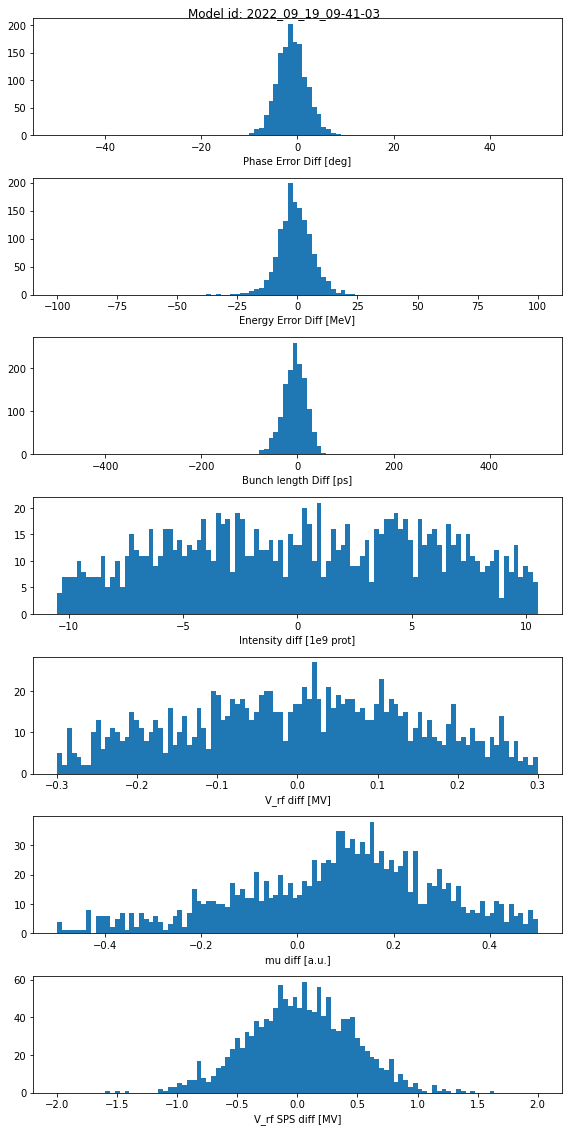

In [14]:

y_test_unnorm = unnormalize_params(
    y_test[:, 0], y_test[:, 1], y_test[:, 2],
    y_test[:, 3], y_test[:, 4], y_test[:, 5],
    y_test[:, 6])

y_pred_unnorm = unnormalize_params(
    test_pred[:, 0], test_pred[:, 1], test_pred[:, 2],
    test_pred[:, 3], test_pred[:, 4], test_pred[:, 5],
    test_pred[:, 6])

diffs = np.array(y_pred_unnorm).T - np.array(y_test_unnorm).T
print(diffs.shape)
fig, axes = plt.subplots(ncols=1, nrows=len(var_names), sharex=False,
                         sharey=False, figsize=(8, 16))
fig.suptitle(f'Model id: {timestamp}')

plt.sca(axes[0])
plt.hist(diffs[:, 0], bins=100, range=(-50, 50))
plt.xlabel('Phase Error Diff [deg]')
plt.sca(axes[1])
plt.hist(diffs[:, 1], bins=100, range=(-100, 100))
plt.xlabel('Energy Error Diff [MeV]')
plt.sca(axes[2])
plt.hist(diffs[:, 2]*1e12, bins=100, range=(-500, 500))
plt.xlabel('Bunch length Diff [ps]')
plt.sca(axes[3])
plt.hist(diffs[:, 3]*1e-10, bins=100, range=(-10.5, 10.5))
plt.xlabel('Intensity diff [1e9 prot]')
plt.sca(axes[4])
plt.hist(diffs[:, 4], bins=100, range=(-0.3, 0.3))
plt.xlabel('V_rf diff [MV]')
plt.sca(axes[5])
plt.hist(diffs[:, 5], bins=100, range=(-0.5, 0.5))
plt.xlabel('mu diff [a.u.]')
plt.sca(axes[6])
plt.hist(diffs[:, 6], bins=100, range=(-2, 2))
plt.xlabel('V_rf SPS diff [MV]')
plt.tight_layout()
# for i, name in enumerate(var_names):
#     hist, edges = np.histogram(square_errors[:, i], bins=100, density=False)
#     hist = hist / len(square_errors[:, i])
#     print(name, hist)
#     ax = axes[i]
#     plt.sca(ax)
#     plt.bar(np.arange(len(hist)), hist, width=0.8)
#     plt.title(name)
#     edges = [f'{e:.4f}' for e in edges]
#     plt.xticks(np.arange(len(hist)), edges[1:])
#     plt.xlabel('Error')
#     plt.ylabel('Density')
#     plt.tight_layout()
